In [165]:
import numpy as np
import random as rd
import pandas as pd
import platform
from random import choices
import scipy.linalg as sl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.linear_model import lasso_path
import time
%matplotlib inline
def Data_Generate(n=3000,p=1000,A_set={3.5,-3.5},true_size=30,sigma=1):
    X=np.random.normal(0,1,(n,p))
    X_mean=np.mean(X,axis=0)
    X=X-X_mean
    X_var=np.power(np.var(X,axis=0),0.5)
    X=X/X_var
    true_feature=pd.Series(range(p)).sample(n=true_size,replace=False).tolist()
    true_beta=choices(list(A_set),k=true_size)
    beta_all=np.zeros((p,1))
    for i,features in enumerate(true_feature):
        beta_all[features,0]=true_beta[i]
    Y=np.dot(X,beta_all)+np.random.normal(0,1,(n,1))
    return (X,true_feature,true_beta,Y,beta_all)
def Knockoff_Construct(X):
    design_var=np.dot(X.T,X)
    p=X.shape[1]
    s=min(np.linalg.eig(design_var)[0])
    uhat=sl.svd(X,full_matrices=True)[0][:,p:2*p]
    CTC=2*s*np.identity(p)-np.dot(s*np.identity(p),np.dot(np.linalg.inv(design_var),s*np.identity(p)))
    C=sl.cholesky(CTC).T
    Xhat=np.dot(X,np.identity(p)-np.dot(np.linalg.inv(design_var),s*np.identity(p)))+np.dot(uhat,C)
    return Xhat
def Simplest_W(X,Xhat,Y):
    return np.where(np.abs(np.dot(X.T,Y))>=np.abs(np.dot(Xhat.T,Y)),np.abs(np.dot(X.T,Y)),-np.abs(np.dot(Xhat.T,Y)))
def Simplest_Z(X,Xhat,Y):
    return (np.abs(np.dot(X.T,Y)),np.abs(np.dot(Xhat.T,Y)))
def Lasso_Z(X,Xhat,Y):
    n=X.shape[0]
    p=X.shape[1]
    X_all=np.array([X.T,Xhat.T]).reshape((-1,n)).T
    alpha,coef,useless1=lasso_path(X_all,Y,eps=1/(p*1000),n_alphas=p*1000)
    Z_True=[]
    Z_Knockoff=[]
    for i in range(p):
        try:
            Z_True.append(alpha[np.nonzero(coef[:,i,:].reshape(-1))[0][0]])
        except IndexError:
            Z_True.append(0)
        try:
            Z_Knockoff.append(alpha[np.nonzero(coef[:,i+p,:].reshape(-1))[0][0]])
        except IndexError:
            Z_Knockoff.append(0)
    return (np.array(Z_True),np.array(Z_Knockoff))
def Lasso_W(X,Xhat,Y):
    Z_True,Z_Knockoff=Lasso_Z(X,Xhat,Y)
    return np.where(Z_True>=Z_Knockoff,Z_True,-Z_Knockoff)
def Find_T(X,Xhat,Y,q,W_Function=Simplist_W):
    W=W_Function(X,Xhat,Y)
    sorted_W=np.sort(W[W>0])
    for item in sorted_W:
        qhat=len(W[W<=-item])/len(W[W>=item])
        if q>qhat:
            return item
    return 'inf'
def FDR_Cal(X,Xhat,Y,q,beta_all,W_Function=Simplist_W):
    T=Find_T(X,Xhat,Y,q,W_Function=W_Function)
    W=W_Function(X,Xhat,Y)
    out=np.array([W.reshape(-1).tolist(),beta_all.reshape(-1).tolist()])
    outcome=pd.DataFrame(out.T,columns=['W','beta'])
    choosen=outcome[outcome.W>=T]
    choosen_true=choosen[choosen.beta!=0]
    print('choosen:'+str(len(choosen)))
    print('choosen true:'+str(len(choosen_true)))
    return 1-len(choosen_true)/len(choosen)
def Plot_Out(X,Xhat,Y,q,beta_all,Z_Function=Simplist_Z,W_Function=Simplist_W):
    Z_True,Z_Knockoff=Z_Function(X,Xhat,Y)
    Z_X_NULL=[]
    Z_Y_NULL=[]
    Z_X_Not_NULL=[]
    Z_Y_Not_NULL=[]
    for i,item in enumerate(beta_all):
        if item==0:
            Z_X_NULL.append(Z_True[i])
            Z_Y_NULL.append(Z_Knockoff[i])
        else:
            Z_X_Not_NULL.append(Z_True[i])
            Z_Y_Not_NULL.append(Z_Knockoff[i])
    Z_max=np.max(np.abs(W_Function(X,Xhat,Y)))
    z= np.linspace(0, Z_max, 50)
    T=Find_T(X,Xhat,Y,q,W_Function=W_Function)
    T1=np.linspace(0, T, 50)
    T2=np.linspace(T, T, 50)
    plt.figure()
    plt.plot(z,z,'--',color='blue')
    plt.plot(T1,T2,color='black')
    plt.plot(T2,T1,color='black')
    p1=plt.scatter(Z_X_NULL, Z_Y_NULL, marker='s', c='black')
    p2=plt.scatter(Z_X_Not_NULL, Z_Y_Not_NULL, marker='s', c='red')
    plt.xlabel('Z True')
    plt.ylabel('Z Knockoff')
    plt.yticks([T],['T='+str(T)])
    plt.xticks([T],['T='+str(T)])
    plt.legend(handles=[p1,p2],labels=['NULL','Not NULL'],loc=0)
    plt.title('Outcome of Simulation')
    plt.show()
    




[63, 600, 780, 55, 515, 434, 282, 28, 511, 245, 319, 859, 650, 691, 713, 15, 445, 165, 252, 685, 75, 627, 758, 262, 793, 52, 353, 34, 85, 49]


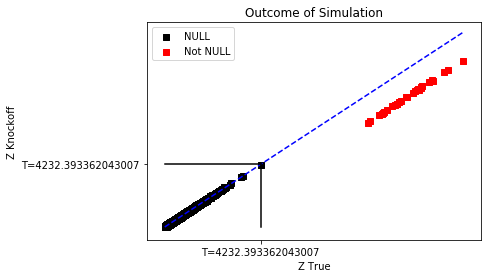

choosen:31
choosen true:30
0.032258064516129004


In [171]:
X,true_feature,true_beta,Y,beta_all=Data_Generate(n=3000,p=1000,A_set={3.5,-3.5},true_size=30)
Xhat=Knockoff_Construct(X)
print(true_feature)
q=0.05
Plot_Out(X,Xhat,Y,q,beta_all,Z_Function=Simplest_Z,W_Function=Simplest_W)
print(FDR_Cal(X,Xhat,Y,q,beta_all,W_Function=Simplest_W))

In [3]:
outcome.sort_values(by=['W'],ascending=False)

,W,beta
631,240.447535,-0.3
672,220.980949,-0.3
987,205.480126,0.3
297,201.160013,0.3
68,190.472088,0.3
411,185.126181,-0.3
83,175.075312,-0.3
133,152.313944,-0.3
536,149.948795,0.3
564,129.807176,-0.2


In [120]:
from sklearn.linear_model import lasso_path
X,true_feature,true_beta,Y,beta_all=Data_Generate(n=100,p=40,A_set={3.5,-3.5},true_size=3)
Xhat=Knockoff_Construct(X)
Lasso_Z(X,Xhat,Y)
begin=time.clock()
alpha,coef,useless1=lasso_path(X,Y,eps=0.001,n_alphas=1000)
time.clock()-begin

(1, 80, 40000)


0.1524909999999977

In [127]:
a=np.array([0,0,0,1,2])
np.nonzero(a)

(array([3, 4]),)

In [87]:
j=0
for i in range(1000):
    a=coef[:,:,i].reshape(-1)
    k=len(a[a!=0])
    if k>j:
        print(k)
        print(alpha[i])
        j=k
    

1
3.762628450302383
2
3.0577448607039517
3
2.933480643546591
4
0.2833793578767625
5
0.2626244638741988
6
0.18844778393324643
7
0.1858596130724883
8
0.1845788881890893
9
0.1698814619126139
10
0.1641084617274299
11
0.15527693523342867
12
0.14692067893203822
13
0.14590827518125268
14
0.1361601099870509
15
0.13244570565504582
16
0.12794486680738676
17
0.10615532528546348
18
0.1004425572912389
19
0.09838043814966292
20
0.09636065500060577
21
0.09373196709485172
22
0.08567393063391388
23
0.08106337259032356
24
0.07059348271746126
25
0.06497234956394139
26
0.059798809257711125
27
0.05776669502328025
28
0.05171654138454305
29
0.04630004627582169
30
0.045036995794478056
31
0.04441845076445189
33
0.04202806381779772
34
0.040881551654099714
35
0.039492293505431736
36
0.03894990026979957
37
0.03841495634632294
38
0.03736700860098006
39
0.03634764853557801
41
0.034870510220727007
42
0.03231657069291835
43
0.030366744954672537
44
0.02644467182456112
45
0.024507846345233036
46
0.021195422877016992
47

In [96]:
a=np.array([[1,2,3],[3,4,4]])
b=np.array([[5,6,4],[7,8,4]])
print(a.shape)
np.array([a.T,b.T]).reshape((-1,2)).T.shape

(2, 3)


(2, 6)

In [78]:
X,true_feature,true_beta,Y=Data_Generate(n=10,p=5,A_set={3.5,-3.5},true_size=3)
Knockoff_Construct(X)

[20.20880725 14.45663283  1.59813476  8.55618237  5.18024279]


In [75]:
np.zeros((3,1)).T

array([[0., 0., 0.]])

In [49]:
rd.sample(range(1000),30)
a=pd.Series(range(10))
a.sample(n=10,replace=True).tolist()

[5, 5, 5, 5, 0, 5, 5, 9, 4, 9]

In [42]:
help(rd.sample)

Help on method sample in module random:

sample(population, k) method of random.Random instance
    Chooses k unique random elements from a population sequence or set.
    
    Returns a new list containing elements from the population while
    leaving the original population unchanged.  The resulting list is
    in selection order so that all sub-slices will also be valid random
    samples.  This allows raffle winners (the sample) to be partitioned
    into grand prize and second place winners (the subslices).
    
    Members of the population need not be hashable or unique.  If the
    population contains repeats, then each occurrence is a possible
    selection in the sample.
    
    To choose a sample in a range of integers, use range as an argument.
    This is especially fast and space efficient for sampling from a
    large population:   sample(range(10000000), 60)



In [37]:
import platform
print (platform.python_version())

3.6.6


In [63]:
Data_Generate(n=10,p=5,A_set={3.5,-3.5},true_size=3)

[-3.5, 3.5, 3.5]


In [3]:
a[1]

TypeError: 'set' object does not support indexing